# **Step 1 -> Import Required Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import copy
from tqdm.notebook import tqdm as tqdm
import time
import timeit

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Step 2 -> Load the CIFAR100 dataset**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset and apply the transformation pipeline
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the sizes of the training, validation, and testing datasets
train_size = int(0.7 * len(trainset))
val_size = int(0.2 * len(trainset))
test_size = len(testset)

# Split the dataset into training, validation, and testing datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    trainset, [train_size, val_size, len(trainset) - train_size - val_size]
)

# Create data loaders for the training, validation, and testing datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# **Step 3 ->  Define the MCUNET model**

In [ ]:
import torch.nn as nn

class MCUNet10FPS(nn.Module):
    def __init__(self, num_classes=10):
        super(MCUNet10FPS, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=1, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, num_classes, bias=True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# **Step 6 -> Train the Model**

In [ ]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model =  MCUNet10FPS().to(device)

In [ ]:
import torch.optim as optim

learning_rate = 0.0001  # learning rate
momentum = 0.5 # momentum factor
epochs = 10
optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
def evaluate(model, data_loader, device=device):
    model.eval()

    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss += nn.CrossEntropyLoss()(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).sum().item()

    loss /= len(data_loader)
    accuracy = 100. * correct / total

    return loss, accuracy

In [ ]:
def train(model, trainloader, val_loader, num_epochs, batch_size, optimizer):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accs = []
    val_accs = []
    val_losses = []
    time1 = []
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))
        with tqdm(total=len(trainloader)):
            for i, data in enumerate(trainloader):

                images, labels = data
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                # pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                #                  Accuracy='{0:.4f}'.format(float(train_acc.item()/(batch_size*(i+1)))))
                #pbar.update(1)

        epoch_loss = train_loss / len(trainloader)
        epoch_acc = 100.0 * float(train_acc.item()) / (len(trainloader) * batch_size)
        val_loss, val_acc = evaluate(model, val_loader, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        end_time = time.time()
        time2 = end_time - start_time
        time1.append(time2)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(epoch_loss, epoch_acc, val_loss, val_acc))
    return train_accs, train_losses, val_accs, val_losses, time1

In [ ]:
model_train_accs, model_train_losses, model_valid_accs, model_valid_losses, time = train(model, trainloader, valloader, 10, 32, optimizer_SGD)


Epoch:  1 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 2.1187, Train Accuracy: 33.31%, Valid Loss: 1.8446, Valid Accuracy: 66.77%

Epoch:  2 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.3073, Train Accuracy: 92.65%, Valid Loss: 0.1098, Valid Accuracy: 96.46%

Epoch:  3 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0857, Train Accuracy: 97.23%, Valid Loss: 0.0908, Valid Accuracy: 97.11%

Epoch:  4 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0571, Train Accuracy: 98.14%, Valid Loss: 0.0803, Valid Accuracy: 97.46%

Epoch:  5 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0406, Train Accuracy: 98.71%, Valid Loss: 0.0772, Valid Accuracy: 97.56%

Epoch:  6 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0319, Train Accuracy: 98.96%, Valid Loss: 0.0519, Valid Accuracy: 98.32%

Epoch:  7 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0236, Train Accuracy: 99.21%, Valid Loss: 0.0635, Valid Accuracy: 98.00%

Epoch:  8 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0178, Train Accuracy: 99.42%, Valid Loss: 0.0454, Valid Accuracy: 98.59%

Epoch:  9 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0127, Train Accuracy: 99.63%, Valid Loss: 0.0688, Valid Accuracy: 97.95%

Epoch:  10 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Loss: 0.0100, Train Accuracy: 99.69%, Valid Loss: 0.0466, Valid Accuracy: 98.58%


In [ ]:
model_valid_accs

[66.76666666666667,
 96.45833333333333,
 97.10833333333333,
 97.45833333333333,
 97.55833333333334,
 98.31666666666666,
 98.0,
 98.59166666666667,
 97.95,
 98.58333333333333]

In [ ]:
model_valid_losses

[1.8446478678385416,
 0.10975522678717971,
 0.09079916286220154,
 0.08025379209282497,
 0.0771939601362683,
 0.05192209503372821,
 0.06347553469706327,
 0.045424145517754366,
 0.0688284453850744,
 0.046562763693820064]

# **Step 7 -> Test on test set**

In [ ]:
model_train_accs

[33.308739527798934,
 92.65041888804265,
 97.22724676313786,
 98.14118431073877,
 98.71477532368621,
 98.95515993907082,
 99.21458492003046,
 99.42402894135567,
 99.62633282559025,
 99.69297410510282]

Evaluating the performance on teacher network using testdata

In [ ]:
evaluate(model, testloader, device)

(0.05263414085532125, 98.58333333333333)

# **Plotting**

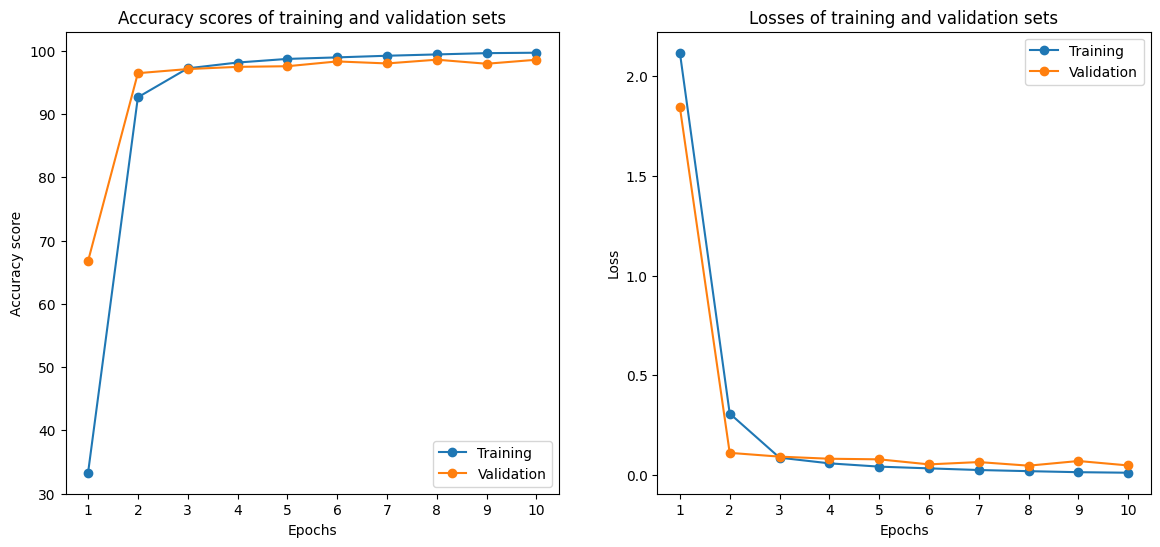

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of training and validation sets
ax1.plot([i+1 for i in range(num_epochs)], model_train_accs, label="Training", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], model_valid_accs, label="Validation", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of training and validation sets")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Losses of training and validation sets
ax2.plot([i+1 for i in range(num_epochs)], model_train_losses, label="Training", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], model_valid_losses, label="Validation", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Losses of training and validation sets")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()